# CNN physical approach

**Author:** Manuela Linke, HTWG Konstanz 

**Date:** 15.03.2024 

**Summary:** This Script reshapes the input data for CNN training, optimizes the hyperparameters and can be used to evaluate the best model with the N-Best Approach.

**License:** Copyright 2024 Manuela Linke

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import numpy as np
import time as t
import datetime as dt
import pandapower as pp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, TensorBoard
import tensorflow as tf
from tensorflow.keras import utils
import sklearn
import pandas as pd
import os
import math
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#region settings
print('TensorFlow version:', tf.__version__)
#print('GPU available:', tf.test.is_gpu_available())
print('Built with CUDA:', tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

TensorFlow version: 2.13.1
Built with CUDA: False



## Parameters to be set

In [3]:
#date = '2024-03-20_22-24-20' # Replace this with the actual date in format yyyy-mm-dd_hh-mm-ss'
date = '2024-03-25_16-56-21'

save_model = True    # save keras model as HDF5 file
log_training = True  # log training to display later in tensorboard

In [4]:
# Defining the paths
path_to_grid = os.path.join('..','1_training data generation', 'cossmic_grid.p')
net = pp.from_pickle(path_to_grid)

input_path = os.path.join('..', '1_training data generation', 'data', 'prepared', '')
version = 'phys' # phys

## Define output folders

In [5]:
folder_models = os.path.join('CNN_models', date, version)
folder_reports = os.path.join('Reports', date, version)
log_dir = os.path.join('logs', 'fit', date, version)

if not os.path.exists(folder_reports):
    os.makedirs(folder_reports)
    
if not os.path.exists(folder_models):
    os.makedirs(folder_models)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

## Function definitions

In [13]:
def get_param_for_auto_pic(net):
    """
    Extracts parameters necessary for automatic picture generation of a network.

    This function processes a network object to determine the connection lines, switch states (converted to integers), and the total number of lines in the network. The switch states are filtered to exclude Trasformer stations and then converted from boolean to integer format.

    Parameters
    ----------
    net : Network
        The network object containing the line and switch data.

    Returns
    -------
    con_line : list of list of int
        A list of lists where each sublist contains the 'from' and 'to' bus IDs of each line.
    switch_state : ndarray
        An array of switch states converted to integers (1 for closed, 0 for open).
    num_lines : int
        The total number of lines in the network.

    """
    num_lines = len(net.line)
    
    switch_state_bool = net.switch[net.switch['et'] != 't']
    switch_state = np.multiply(switch_state_bool.closed.tolist(), 1) # convert the boolean switch states to int

    con_line = net.line.from_bus

    from_bus_list = net.line.from_bus.tolist()
    to_bus_list = net.line.to_bus.tolist()

    con_line = [[from_bus, to_bus] for from_bus, to_bus in zip(from_bus_list, to_bus_list)]
    
    return con_line, switch_state, num_lines

In [14]:
def build_input_pic(load, net):


    """
         Executes the function get_param_for_auto_pic to generate with this information and the given data images automatically.
         INPUT:
            **load** - (np.array(len(data),participants)) that holds as many rows as there are training examples. For each training example it holds the load values for the 11 paticipants in the cossmic grid.
         OUTPUT:
            **build_input_pic[len(load),lines,3]** - is a matrix witch len(loads) pictures as input for the CNNs
                pictures are structured as followed for the cossmic-grid example:

                'load[ind_2]'	switch_state[lv_ind_2_ind_3]	'load[ind_3]'
                'load[ind_3]'	switch_state[lv_ind_3_ind_1]	'load[ind_1]'
                'load[ind_1]'	switch_state[lv_ind_1_ind_2]	'load[ind_2]'
                'load[ind_3]'	switch_state[lv_ind_3_res_3]	'load[res_3]'
                'load[res_3]'	switch_state[lv_res_3_res_2]	'load[res_2]'
                'load[res_2]'	switch_state[lv_res_2_res_1]	'load[res_1]'
                'load[res_1]'	switch_state[lv_res_1_pub_1]	‘load[pub_1]'
                ‘load[pub_1]'	switch_state[lv_pub_1_res_6]	‘load[res_6]’
                'load[res_3]'	switch_state[lv_res_3_res_4]	'load[res_4]'
                'load[res_4]'	switch_state[lv_res_4_res_5]	'load[res_5v'
                'load[res_5]'	switch_state[lv_res_5_pub_2]	'load[pub_2]'
                'load[pub_2]'	switch_state[lv_pub_2_res_6]	'load[res_6]'

                the switch_state is in the middle

            EXAMPLE:
            build_input_pic(load)

         """

    con_line, switch_state, num_lines = get_param_for_auto_pic(net)
    # pic dimensions num_lines, 3(line_in, switch_state, line_out)
    # there will be as many inputpics as entries in ch1
    auto_pic_lines_mid = np.zeros((len(load), num_lines, 3))
    for i in range(len(load)):
        # con_line entries hol starting and endpoints
        for count, line_in_and_out in enumerate(con_line):
        # pos 0 start
        # pos 1 switch_state 
        # pos 2 end
            auto_pic_lines_mid[i, count, 0] = load[i, line_in_and_out[0]] #in
            auto_pic_lines_mid[i, count, 1] = switch_state[count]
            auto_pic_lines_mid[i, count, 2] = load[i, line_in_and_out[1]] #out

    return auto_pic_lines_mid

In [15]:
def get_uncompiled_model(pic_dim1, pic_dim2, num_classes,
                         numFilters_Layer1=32, numFilters_Layer2=64, numNeurons_Layer3=264,
                         dropout_1=0.5, dropout_2=0.4):

    """
        composes the Keras sequential model
        INPUT:
            **pic_dim1** - (int+) sets the x dimension of the input picture int
            **pic_dim2** _ (int+)  sets the y dimension of the input picture int
        OPTIONAL:
            **numFilters_Layer1** - (int+,32)sets  Integer, the dimensionality of the output space of the first con_layer (i.e. the number of output filters in the convolution).
            **numFilters_Layer2** - (int+,64)sets  Integer, the dimensionality of the output space of the second con_layer
            **numNeurons_Layer3** - (int+,264) dimensionality of the first dense_layer output
            **dropout_1** - (float, 0.5) between 0 and 1. Fraction of the input units to drop, for the first dropout
            *+dropout_2** - (float, 0.4) between 0 and 1. Fraction of the input units to drop, for the second dropout

        OUTPUT:
            **model** - Keras sequential model of the parametrised CNN

        """

    numNeurons_Layer4 = num_classes  # outputLayer, depending on the number of possible solutions

    model = Sequential()

    model.add(Conv1D(numFilters_Layer1, 3, padding='valid', activation='relu', input_shape=(pic_dim1, pic_dim2)))
    # model.add(AveragePooling1D(2))
    # model.add(MaxPooling1D(2))
    model.add(Conv1D(numFilters_Layer2, 3, activation='relu'))
    #model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dropout(dropout_1))
    model.add(Dense(numNeurons_Layer3, activation='relu'))
    model.add(Dropout(dropout_2))
    model.add(Dense(numNeurons_Layer4, activation='softmax'))

    return model


In [16]:
def get_compiled_model(optimizer, pic_dim1, pic_dim2, num_classes,
                       numFilters_Layer1 = 32, numFilters_Layer2 = 64, numNeurons_Layer3 = 264,
                       dropout_1 = 0.5 , dropout_2 = 0.4):
    """
         compiles the sequential model und prints out the summary
        INPUT:
            **optimizer** - (string) sets common keras optimizer parsed as string
            **pic_dim1** - (int+) sets the x dimension of the input picture int
            **pic_dim2** _ (int+)  sets the y dimension of the input picture int
        OPTIONAL:
            **numFilters_Layer1** - (int+,32)sets  Integer, the dimensionality of the output space of the first con_layer (i.e. the number of output filters in the convolution).
            **numFilters_Layer2** - (int+,64)sets  Integer, the dimensionality of the output space of the second con_layer
            **numNeurons_Layer3** - (int+,264) dimensionality of the first dense_layer output
            **dropout_1** - (float, 0.5) between 0 and 1. Fraction of the input units to drop, for the first dropout
            *+dropout_2** - (float, 0.4) between 0 and 1. Fraction of the input units to drop, for the second dropout

        OUTPUT:
            **model** - Keras sequential model of the parametrised CNN

        """

    model = get_uncompiled_model(pic_dim1, pic_dim2, num_classes,
                                 numFilters_Layer1, numFilters_Layer2, numNeurons_Layer3, 
                                 dropout_1, dropout_2)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    model.summary()
    return model

In [17]:
def train_model_for_build_input_pic(
        optimizer, num_classes, 
        folder_models, folder_reports,
        X_train, Y_train,
        X_val, Y_val,
        X_test, Y_test,
        bs, ep, version, 
        log_dir, save_model=True):
    """
    executes the composing und compiling process of the network (Sequential model)
    to train the resulting model on the given trainingdata.
    The input data is generated using  build_input_pic or any other function that encodes the lines with the load.
    It has thee dimension np.array(len(data),lines,3)
    Afterwards the net gets testet and the model will be stored with a unequivocally name in the folder "Daten CNN model".


        INPUT:
            **X_train** -       (np.array(len(data),lines,3))holds the compose_3ChannelOneDV1 pics for the trainingdata
            **Y_train** -   (np.array(len(data),lines))  holds an zero np.array for the number of trainingsamples
            **X_val** -         (np.array(len(data),lines,3))compose_3ChannelOneDV1 pics for the validationdata
            **Y_val** -     (np.array(len(data),lines))  holds an zero np.array for the number of validationsamples
            **X_test** -        (np.array(len(data),lines,3))compose_3ChannelOneDV1 pics for the testdata
            **Y_test** -    (np.array(len(data),lines))  holds an zero np.array for the number of testingsamples

            needed for a inside the function called function
            **optimizer** - (string) sets common keras optimizer parsed as string

        OPTIONAL:
            **bs** - (int,32) or None. Number of samples per gradient update. Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).
            **ep** - (int,30) Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch".

            needed for a inside the function called function
            **numFilters_Layer1** - (int+,128)sets  Integer, the dimensionality of the output space of the first con_layer (i.e. the number of output filters in the convolution).
            **numFilters_Layer2** - (int+,128)sets  Integer, the dimensionality of the output space of the second con_layer
            **numNeurons_Layer3** - (int+) dimensionality of the first dense_layer output
            **dropout_1** - (float, 0.5) between 0 and 1. Fraction of the input units to drop, for the first dropout
            *+dropout_2** - (float, 0.4) between 0 and 1. Fraction of the input units to drop, for the second dropout

        """

    print("Training the CNN..")
    model = get_compiled_model(optimizer = optimizer, pic_dim1 = X_train.shape[1], pic_dim2 = X_train.shape[2], num_classes = num_classes) # num_classes = number of possible solutions
   
    #model.summary()
    #####

    t00 = t.time()

    callbacks = [
        CSVLogger(os.path.join(log_dir, 'bs_' + str(bs) + '-ep_' + str(ep) + '-op_' + optimizer + "_" + version + '_logging.csv'))  # training.log
    ]
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    '''    EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1,
        ),'''

    history = model.fit(X_train,
                        Y_train,
                        batch_size=bs,
                        epochs=ep,
                        verbose=0, # verbose=0: Outputs nothing, verbose=1: Generates an output for each epoch (standard behaviour), including a progress bar.
                        callbacks=callbacks,
                        validation_data=(X_val, Y_val))  

    t11 = t.time()
    ######
    ######
    tt_elapsed = t11 - t00
    print("   Time elapsed for training: %d:%02d m:sec"
          % (tt_elapsed / 60, (tt_elapsed / 60 - math.floor(tt_elapsed / 60)) * 60))

    y_pred = model.predict(X_test)
    
    report = classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1), zero_division=0)
    print(report)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    print(f"Loss on test dataset: {test_loss:.4f}")
    print(f"Testaccuracy: {test_accuracy:.4f}")

    #######
    #######
    # Save neural network
    if save_model:  # creates a '_model.keras'-file, can be loaded by keras.model.load_model()
        
        filename = os.path.join(folder_reports, date + '-' + 'bs_' + str(bs) + '-ep_' + str(ep) + '-op_' + optimizer + "_" + version + '_classification_report.txt')

        
        with open(filename, 'w') as file:
            file.write(report)
        
        os.makedirs(folder_models, exist_ok=True)
        model.save(os.path.join(folder_models, date + '-' + 'bs_' + str(bs) + '-ep_' + str(ep) + '-op_' + optimizer + "_" + version + '_model.keras'))
                   

    return test_loss, test_accuracy, train_loss, val_loss

## Loading and analysing the data

In [18]:
# load data
X_train_std_load = np.load(os.path.join(input_path, date + "_X_train_std_load.npy" ))
X_val_std_load = np.load(os.path.join(input_path, date + "_X_val_std_load.npy"))
X_test_std_load = np.load(os.path.join(input_path, date + "_X_test_std_load.npy"))
X_train_std_voltage = np.load(os.path.join(input_path, date + "_X_train_std_volt.npy"))
X_val_std_voltage = np.load(os.path.join(input_path, date + "_X_val_std_volt.npy"))
X_test_std_voltage = np.load(os.path.join(input_path, date + "_X_test_std_volt.npy"))


# load output
Y_train = np.load(input_path + date + "_Y_train.npy")
Y_val = np.load(input_path + date + "_Y_val.npy")
Y_test = np.load(input_path + date + "_Y_test.npy")

num_classes = Y_train.shape[1]

Shape of new CNN training input data:  (36790, 12, 3)
Shape of new CNN val input data:  (7884, 12, 3)
Shape of new CNN test input data:  (7884, 12, 3)


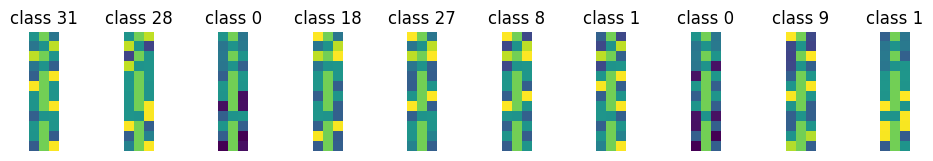

In [19]:
# auto_compose_pics_lines_mid
X_train = build_input_pic(X_train_std_load, net)
X_test =  build_input_pic(X_test_std_load, net)
X_val =   build_input_pic(X_val_std_load, net)
print('Shape of new CNN training input data: ', X_train.shape)
print('Shape of new CNN val input data: ', X_val.shape)
print('Shape of new CNN test input data: ', X_test.shape)

# Plot first 5 samples and its corresponding classes
plt.figure(3, figsize=(12, 9))

vmin, vmax = np.min(X_train), np.max(X_train)  # Beispielwerte, an deine Daten anpassen

for i in range(10):
    img = X_train[i]
    plt.subplot(5,10,i+1)
    plt.title('class ' + str(Y_train.argmax(axis=1)[i]))
    #print(img)
    plt.imshow(img.reshape(12,3), cmap='viridis', vmin=vmin, vmax=vmax)
    plt.axis('off')

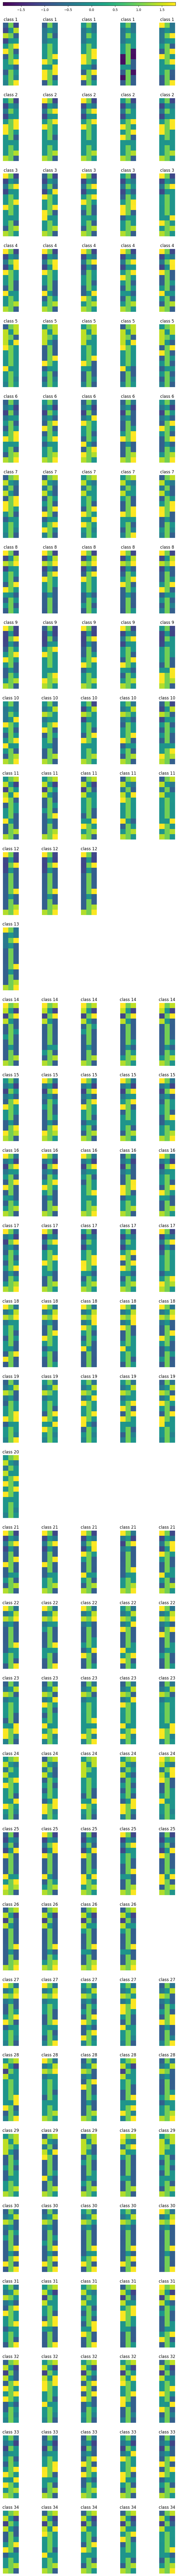

In [20]:
## plotting the samples according to their classes to find out similarities in the data
plots_dir = os.path.join(log_dir, 'data_plots')
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

maxImg = 5
numImg = 0
plt.figure(2, figsize=(maxImg*2, num_classes*4))
categories = list(range(1, num_classes + 1))

for n, category in enumerate(categories):
    numImg = 0
    for i, y in enumerate(Y_train):
        if np.argmax(y) == category:
            numImg += 1
            img = X_train[i]
            plt.subplot(len(categories),maxImg,n*maxImg+numImg)
            plt.title('class ' + str(np.argmax(y)))
            im = plt.imshow(img.reshape(12, 3), cmap='viridis', vmin=vmin, vmax=vmax) 
            plt.axis('off')
            if numImg>=maxImg:
                break

# Adding a Colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm = plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar_ax = plt.gcf().add_axes([0.16, 0.885, 0.708, 0.001]) 
plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')

plot_path = os.path.join(plots_dir, date +  f'_samples_per_classes_of_the_training_data_set.png')
plt.savefig(plot_path, bbox_inches='tight')

## Hyperparameter optimization
this takes about 2,5 hours for 7883 simulation data 

In [18]:
from itertools import product

# optimizer list
op_list = ['adam', 'Nadam', 'RMSprop']
# batch_size
bs_list = [16, 32, 64, 128]
# epoch_list
ep_list = [80, 100, 200]

# Combinations of all hyperparameters
hyperparameter_combinations = list(product(op_list, bs_list, ep_list))

results = []
# checking all the combinations
for optimizer, bs, ep in hyperparameter_combinations:
    test_loss, test_accuracy, train_loss, val_loss = train_model_for_build_input_pic(optimizer=optimizer, num_classes=num_classes, folder_models=folder_models, folder_reports=folder_reports, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, X_test=X_test, Y_test=Y_test, bs=bs, ep=ep, version=version, log_dir=log_dir)

    results.append({
            'optimizer': optimizer,
            'batch_size': bs,
            'epochs': ep,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy
        })

df_results = pd.DataFrame(results)

print(df_results)

# Save as .csv-file
df_results.to_csv(os.path.join(folder_reports, date + "_" + version + '_model_performance_summary.csv'), index=False)

Training the CNN..
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 10, 32)            320       
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 64)             6208      
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 264)               135432    
                                                                 
 dropout_5 (Dropout)         (None, 264)               0         
                                                                 
 dense_5 (Dense)             (None,

UnknownError: Failed to WriteFile: \\?\A:\9_Workspace\Manu\5_Veröffentlichungen\CNN Paper\Skripte\7_gitlab\cnn_paper\2_training\logs\fit\2024-03-25_16-56-21\phys\bs_16-ep_80-op_RMSprop_phys_logging.csv : Der Netzwerkpfad wurde nicht gefunden.
; Unknown error

## The best combination

In [26]:
# set the parameter for training 
#batch size
bs = 64
#epochs
ep = 200
optimizer = 'adam'

#training 'new'
test_loss, test_accuracy, train_loss, val_loss = train_model_for_build_input_pic(optimizer = optimizer, num_classes = num_classes, folder_models = folder_models, folder_reports=folder_reports, X_train = X_train, Y_train = Y_train, X_val = X_val, Y_val = Y_val, X_test = X_test, Y_test = Y_test, bs = bs, ep = ep, version=version, log_dir=log_dir, save_model = True)

Training the CNN..
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            320       
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             6208      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 264)               135432    
                                                                 
 dropout_1 (Dropout)         (None, 264)               0         
                                                                 
 dense_1 (Dense)             (None, 3

## N-Best evaluation

In [7]:
# from tqdm import trange, tqdm
import progressbar as PB
import numpy as np


def pbRange(iterations):
    '''Displays a progress bar while doing an iteration over a range.
    Example:         for i in pbRange(42)
    Same usage as:   for i in range(42)'''
    return PB.progressbar(range(iterations))


def pb(iteratable):
    '''Displays a progress bar while doing an iteration over an iteratable.
    Example:         for element in pb([myList])
    Same usage as:   for elment in myList'''
    return PB.progressbar(iteratable)

def eval_Nbest(model, X_test, Y_test, N=3, verbose=0):
    '''Evalute model's "N-best prediction accuracy",
    according to the N first ranked classes (highest prediction probabilities)

    Example:  Nbest = eval_Nbest(model, X_test, Y_test, 3)

    Returns:  list of three elements
      [0]  (float) calculated prediction accuracy according to N-best ranking
      [1]  (int)   number of correct predictions according to N-best ranking
      [2]  (list)  indices of incorrect predictions according to N-best ranking

    Arguments:
      model :   Keras model (neural network)
      X_test:   Array of input samples for keras model
      y_test:   associated solutions for input samples
      N:        use first N ranked classes (descending probabilities) for evaluation
      verbose:  0 or 1, if printing progress is desired during evaluation
    '''
    if N < 1:
        N = 1
    # predictions will contain a prediction probability value for each class
    predictions = model.predict(X_test, verbose=verbose)
    # check if N > number of classes
    if N > predictions.shape[1]:
        N = 1
    ind = np.argpartition(predictions, -N)[:, -N:]
    # if solution vectors are 1-hot-encoded, convert to decimal values, i.e. [0, 0, 1, 0] --> "2"
    if len(Y_test.shape) > 1:  # if there is a 2nd dimension in the numpy array of solution vectors
        y_test = np.argmax(Y_test, axis=1)
    else:
        y_test = Y_test
    # correct predictions: correct class (y) is among the N-best ranked probabilities of each sample
    correct = 0     # number of correct predictions according to N-best
    incorrect = []  # indices of incorrect predictions
    if verbose:
        for k, y in enumerate(pb(y_test)):
            if np.isin(y, ind[k]):
                correct += 1
            else:
                incorrect.append(k)
    else:
        for k, y in enumerate(y_test):
            if np.isin(y, ind[k]):
                correct += 1
            else:
                incorrect.append(k)
    acc_n_best = correct / len(y_test)
    return [acc_n_best, correct, incorrect]


In [24]:
#Lod the model
model_name = '2024-03-25_16-56-21-bs_64-ep_200-op_adam_phys_model.keras'
model = tf.keras.models.load_model(os.path.join('CNN_models', date, version, model_name))
bs = 64
#epochs
ep = 200
optimizer = 'adam'

In [21]:
# Test neural network using test data
score = model.evaluate(X_test, Y_test, verbose=1)
test_acc = score[1]
print("Test accuracy:", test_acc)

247/247 [==============================] - 1s 2ms/step - loss: 0.0287 - accuracy: 0.9906
Test accuracy: 0.9906138777732849


In [22]:
t00 = t.time()
Nbest_vec=[]
for N in range(1,5):
    print('N = ' + str(N))
    Nbest = eval_Nbest(model, X_test, Y_test, N, verbose=0)
    Nbest_vec.append(Nbest[0])
    print('Test accuracy N-best:', Nbest[0])
    #print('Correctly predicted samples:', Nbest[1])
    #print('Indices of wrongly predicted samples:', Nbest[2])
    print('--------------------------------------------------')
t11 = t.time()
tt_elapsed = t11 - t00
print("Time elapsed: %.1f sec." %tt_elapsed)

N = 1
Test accuracy N-best: 0.9906139015728057
--------------------------------------------------
N = 2
Test accuracy N-best: 0.9991121258244546
--------------------------------------------------
N = 3
Test accuracy N-best: 0.9998731608320649
--------------------------------------------------
N = 4
Test accuracy N-best: 1.0
--------------------------------------------------
Time elapsed: 2.6 sec.


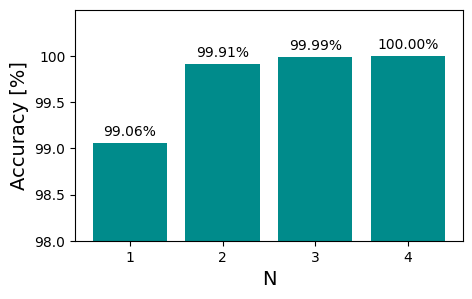

In [32]:
plt.figure(figsize=(5, 3))
N = range(1,5)
bars = plt.bar(N, Nbest_vec, color='darkcyan')

# Set title and axis
#plt.title('Accuracy for the N highest rated solutions', fontsize=16)
plt.xlabel('N', fontsize=14)
plt.ylabel('Accuracy [%]', fontsize=14)

# defining axis
plt.ylim(0.98, 1.005)
plt.yticks([0.98, 0.985, 0.99, 0.995, 1.00], [98.0, 98.5, 99.0, 99.5, 100])
plt.xticks([1, 2, 3, 4])


#showing the percentage values above each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2%}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), 
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.savefig(os.path.join(folder_reports, date + '-' + 'bs_' + str(bs) + '-ep_' + str(ep) + '-op_' + optimizer + "_" + version + '_N-best_plot.png'), dpi=600, bbox_inches='tight')
# Show Plot
plt.show()

In [23]:
# Testing N-best at one specific example
idx = 1136
pred = predictions[idx]
print('associated solution:', np.argmax(Y_test[idx]))
print('predicted solution: ', np.argmax(predictions[idx]))
print('class: probability')
for i, prob in enumerate(pred):
    print(str(i) + ': %7.4f %%' %(prob*100))

associated solution: 28
predicted solution:  28
class: probability
0:  0.0000 %
1:  0.0000 %
2:  0.0000 %
3:  0.0000 %
4:  0.0000 %
5:  0.0000 %
6:  0.0000 %
7:  0.0000 %
8:  0.0000 %
9:  0.0000 %
10:  0.0000 %
11:  0.0000 %
12:  0.0000 %
13:  0.0000 %
14:  0.0000 %
15:  0.0000 %
16:  0.0000 %
17:  0.0000 %
18:  0.0000 %
19:  0.0000 %
20:  0.0000 %
21:  0.0000 %
22:  0.0000 %
23:  0.0000 %
24:  0.0000 %
25:  0.0000 %
26:  0.0000 %
27:  0.0000 %
28: 100.0000 %
29:  0.0000 %
30:  0.0000 %
31:  0.0000 %


## For plotting the model

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot, graphviz

# Defining the model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, 3, activation='relu'),
    Flatten(),
    Dropout(0.5),
    Dense(264, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Print summary
model.summary()

# Plot model to .png
plot_model(model, to_file='model_architecture-physical_approach.png', show_shapes=True, show_layer_names=True)